Code from https://www.kaggle.com/code/revathim05/resnet-model-melanoma-classification/notebook. All comments are modified.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
import cv2
import pandas as pd
import time
import wandb
from PIL import Image
from sklearn.metrics import roc_curve, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn.functional as F
import ssl
_create_unverified_https_context = ssl._create_unverified_context
ssl._create_default_https_context = _create_unverified_https_context

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <F6236B89-E4CA-3330-B665-E463D537EAF3> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F8622D92-25A9-3A61-A089-C917FDA36C1B> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
PARAMS = {
    'epochs': 10,
    'learning_rate': 0.001,
    'batch_size': 32,
    'optimizer': 'sgd',  # 'adam', 'rmsprop', 'sgd', etc.
    'loss_function': 'cross_entropy', # 'cross_entropy','BCE'
    'momentum': 0.0,  # Add momentum for SGD optimizer
    'model_architecture': 'resnet34',  # Change to any other model
    'train_image_path' : 'data/train/',
    'train_csv_path' : 'data/train.csv',
    'test_image_path' : 'data/test/',
    'test_csv_path' : 'data/test.csv'
    
}
#wandb.init(project="SIIM ISIC RESNET18 Model", save_code=True, config=PARAMS)

In [3]:
train_image_path = PARAMS['train_image_path']
test_image_path = PARAMS['test_image_path']

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.RandomRotation(45),      # Random rotation (-45 to +45 degrees)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
def load_and_preprocess_images(image_paths, mode='train', transform=None):
    images = []
    for path in image_paths:
        # Load image using OpenCV
        if mode == "test":
            img = cv2.imread(test_image_path + path + '.jpg')  
        else:
            img = cv2.imread(train_image_path + path + '.jpg')
        pil_img = Image.fromarray(img)
        # Apply data transformations if provided
        if transform is not None:
            augmented_img = transform(pil_img)
            
        images.append(np.array(augmented_img))
    return np.array(images)

In [6]:
# Define the function to load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        # Load image using OpenCV
        img = cv2.imread(train_image_path + path + '.jpg')
        # Convert image to grayscale
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images.append(img)
    return np.array(images)

In [7]:
train_df = pd.read_csv(PARAMS['train_csv_path'])
test_df = pd.read_csv(PARAMS['test_csv_path'])
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [8]:
class_distribution = train_df['target'].value_counts()
class_distribution

0    32542
1      584
Name: target, dtype: int64

In [9]:
X = train_df['image_name'] #images
y = train_df['target'] #target

In [10]:
# Assuming X and y are your original data and labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
majority_class = X_train[y_train == 0]
minority_class = X_train[y_train == 1]

In [12]:
undersampled_majority_class = resample(majority_class,
                                        replace=False,
                                        n_samples=len(minority_class),
                                        random_state=42)

In [13]:
# Load and preprocess images for majority class
undersampled_majority_images = load_and_preprocess_images(undersampled_majority_class,"train",transform=data_transforms)
# Convert labels to float
undersampled_majority_labels = np.zeros(len(undersampled_majority_images))

# Load and preprocess images for minority class
minority_images = load_and_preprocess_images(minority_class,"train",transform=data_transforms)
# Convert labels to float
minority_labels = np.ones(len(minority_images))

In [14]:
# Combine minority class with undersampled majority class
undersampled_X_train = np.concatenate([undersampled_majority_images, minority_images])
undersampled_y_train = np.concatenate([undersampled_majority_labels, minority_labels])


undersampled_X_train_tensor = torch.tensor(undersampled_X_train, dtype=torch.float32)
undersampled_y_train_tensor = torch.tensor(undersampled_y_train, dtype=torch.float32)

In [15]:
# Shuffle the data
shuffled_indices = np.random.permutation(len(undersampled_y_train))
undersampled_X_train = undersampled_X_train_tensor[shuffled_indices]
undersampled_y_train = undersampled_y_train_tensor[shuffled_indices]

In [16]:
undersampled_dataset = TensorDataset(undersampled_X_train_tensor, undersampled_y_train_tensor.long())

In [17]:
# Define data loader
batch_size = PARAMS['batch_size']
#undersampled_dataset.transform = data_transforms
undersampled_dataloader = DataLoader(undersampled_dataset, batch_size=batch_size, shuffle=True)
len(undersampled_dataset)

930

In [18]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [19]:
val_images = load_and_preprocess_images(X_val,"train",transform=data_transforms)
val_labels = np.array(y_val)

val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

# Create validation dataset
val_dataset = TensorDataset(torch.tensor(val_images, dtype=torch.float32), val_labels_tensor)

# Define validation data loader
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:

model = getattr(torchvision.models, PARAMS['model_architecture'])(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2).to(device) 

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/lindsaystrong/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 34.5MB/s]


In [23]:
def get_optimizer_and_criterion(PARAMS, model):
    # Update the loss function based on the PARAMS
    if PARAMS['loss_function'] == 'cross_entropy':
        criterion = nn.CrossEntropyLoss()
    elif PARAMS['loss_function'] == 'BCE':
        criterion = nn.BCEWithLogitsLoss()
    # Add more conditions for other loss functions as needed
    else:
        raise ValueError(f"Unsupported loss function: {PARAMS['loss_function']}")

    # Update the optimizer based on the PARAMS
    if PARAMS['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=PARAMS['learning_rate'])
    elif PARAMS['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=PARAMS['learning_rate'])
    elif PARAMS['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=PARAMS['learning_rate'], momentum=PARAMS['momentum'])
    else:
        raise ValueError(f"Unsupported optimizer: {PARAMS['optimizer']}")

    return optimizer, criterion

In [24]:
def train_model(model, criterion, optimizer, undersampled_dataloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for inputs, labels in undersampled_dataloader:
        optimizer.zero_grad()                
        # Print the shape of the input tensor
        #inputs = inputs.permute(0, 3, 1, 2)  # Rearrange dimensions
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()    
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    end_time = time.time()
    train_time = end_time - start_time
    
    training_loss = running_loss / len(undersampled_dataloader)
    training_accuracy = 100 * correct / total
    
    return training_loss,training_accuracy,train_time

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def validate_model(model, criterion, val_loader, device):
    model.to(device)

        # Validation loop
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels = []
    start_time = time.time()

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_dataloader:
        # Ensure correct data type and device for input data
            val_inputs = val_inputs.to(device, dtype=torch.float32)
            val_labels_batch = val_labels_batch.to(device, dtype=torch.long)

            # Rearrange dimensions if necessary
            #val_inputs = val_inputs.permute(0, 3, 1, 2)

            # Forward pass
            val_outputs = model(val_inputs)

            # Calculate loss
            val_loss = criterion(val_outputs, val_labels_batch)
            val_running_loss += val_loss.item()

                # Append predictions and true labels
            val_preds.extend(torch.argmax(val_outputs, axis=1).cpu().numpy())
            val_labels.extend(val_labels_batch.cpu().numpy())

            # Calculate accuracy
            val_total += val_labels_batch.size(0)
            val_correct += (torch.argmax(val_outputs, axis=1) == val_labels_batch).sum().item()

    # Calculate validation loss
    val_loss = val_running_loss / len(val_dataloader)

    # Calculate validation accuracy
    val_accuracy = 100 * val_correct / val_total

    end_time = time.time()
    val_time = end_time - start_time

    # Calculate precision, recall, and F1 score
    precision = precision_score(val_labels, val_preds,average='weighted')
    recall = recall_score(val_labels, val_preds,average='weighted')
    f1 = f1_score(val_labels, val_preds,average='weighted')
    
    conf_matrix = confusion_matrix(val_labels, val_preds, normalize='true')  # Normalize confusion matrix
    class_names = ['benign', 'malignant'] 
    # Plot confusion matrix with class names
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt=".2%", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


    return val_loss, val_accuracy,val_time,precision,recall,f1,conf_matrix


In [27]:
def test_model(test_loader, model, device, test_df):
    model.eval()
    predictions = []
    image_names = []

    test_start_time = time.time()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            outputs = model(data)

            probabilities = (torch.sigmoid(outputs) >= 0.5).cpu().numpy()
            predictions.extend(probabilities.flatten())

            image_names.extend(test_df['image_name'][i * test_loader.batch_size:(i + 1) * test_loader.batch_size])

    test_end_time = time.time()
    test_time = test_end_time - test_start_time

    submission_df = pd.DataFrame({'image_name': image_names, 'target': predictions})
    submission_df.to_csv('resnet_submission.csv', index=False)

    print(f'Test Evaluation and Submission CSV is generated in: {test_time} seconds')

Epoch 1, Train Loss: 0.6362153589725494, Train Accuracy: 63.01075268817204%, Train Time: 122.91966891288757 seconds


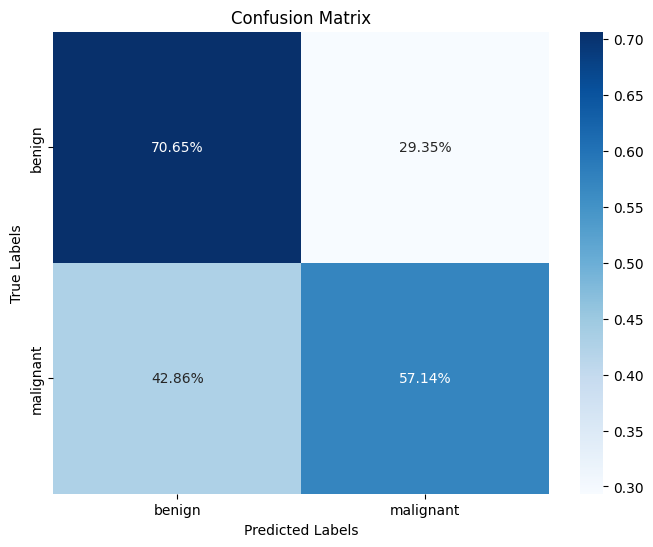

Validation Loss: 0.6025959867984056, Validation Accuracy: 70.40446725022638% Validation Time: 298.01844811439514 seconds
Precision: 0.9718824623458159,Recall: 0.7040446725022638, F1_Score: 0.8105668087697173
Epoch 2, Train Loss: 0.6003043532371521, Train Accuracy: 69.03225806451613%, Train Time: 134.42155480384827 seconds


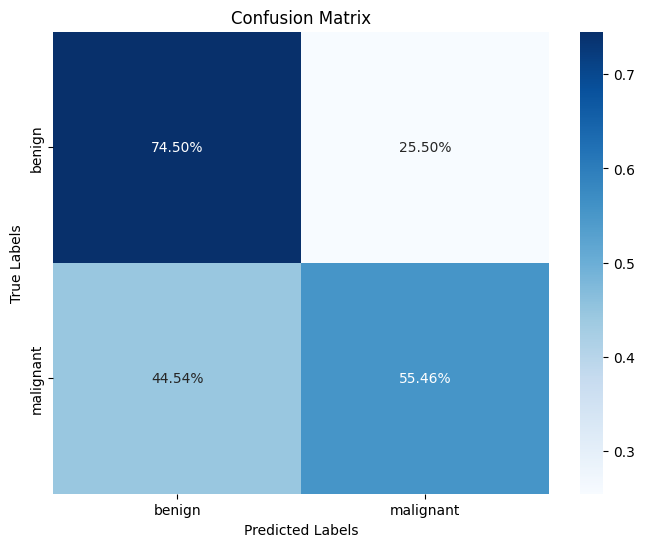

Validation Loss: 0.5625898403903613, Validation Accuracy: 74.16239058255357% Validation Time: 297.3103859424591 seconds
Precision: 0.9721076920393843,Recall: 0.7416239058255357, F1_Score: 0.8359511208598591
Epoch 3, Train Loss: 0.5297119706869126, Train Accuracy: 74.94623655913979%, Train Time: 131.6912808418274 seconds


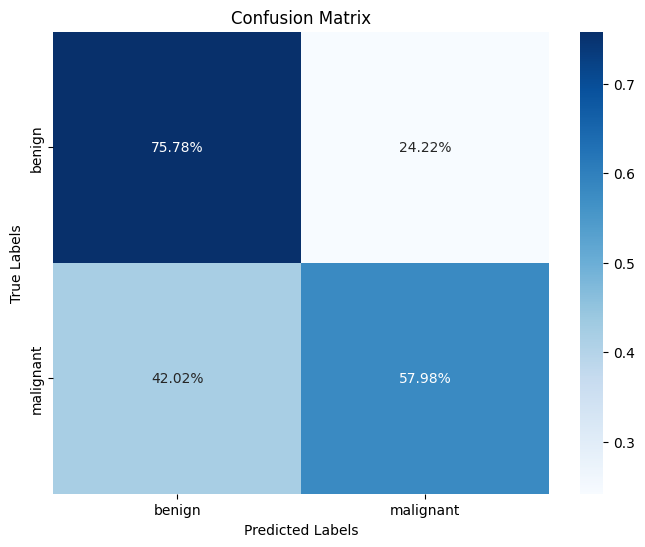

Validation Loss: 0.5399786791262718, Validation Accuracy: 75.46030787805614% Validation Time: 288.4376451969147 seconds
Precision: 0.9729359010212438,Recall: 0.7546030787805614, F1_Score: 0.8444484257372279
Epoch 4, Train Loss: 0.5042002926270167, Train Accuracy: 77.95698924731182%, Train Time: 128.23154091835022 seconds


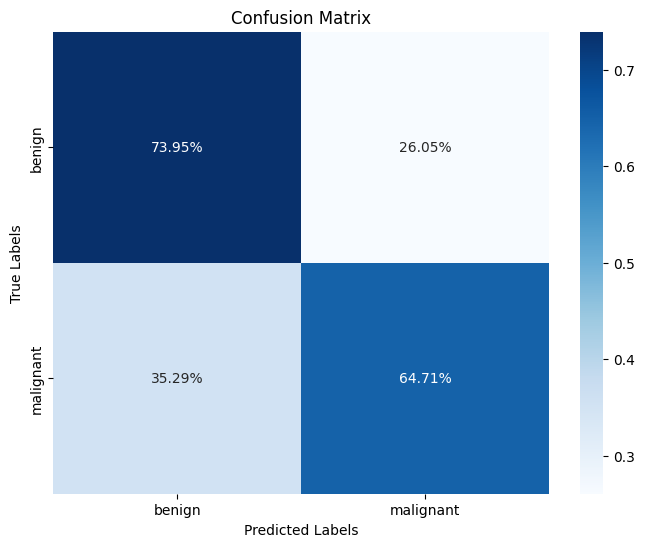

Validation Loss: 0.545330814157541, Validation Accuracy: 73.7850890431633% Validation Time: 294.95020604133606 seconds
Precision: 0.9743235964702568,Recall: 0.737850890431633, F1_Score: 0.8333574355659622
Epoch 5, Train Loss: 0.47922041416168215, Train Accuracy: 79.24731182795699%, Train Time: 133.43083786964417 seconds


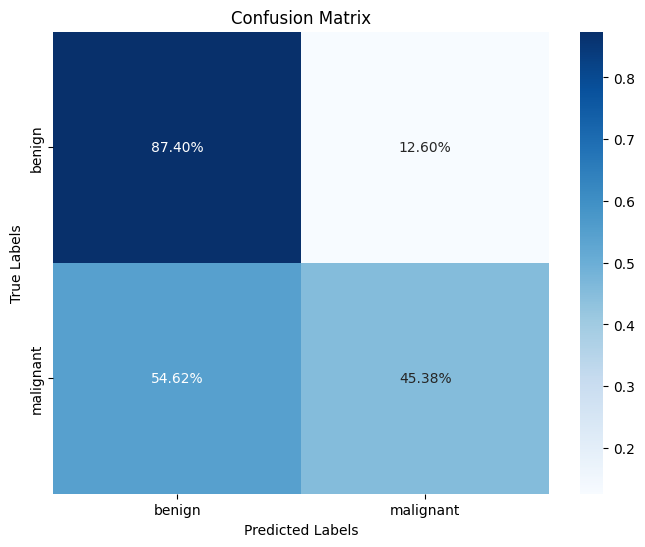

Validation Loss: 0.3647995132666368, Validation Accuracy: 86.64352550558407% Validation Time: 440.57132482528687 seconds
Precision: 0.972052609074122,Recall: 0.8664352550558406, F1_Score: 0.9130984261090898
Epoch 6, Train Loss: 0.45743128955364226, Train Accuracy: 79.78494623655914%, Train Time: 147.34376978874207 seconds


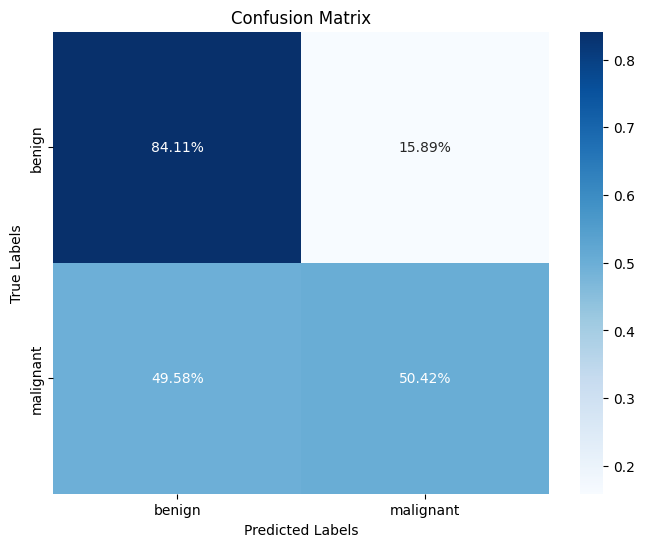

Validation Loss: 0.3957046215923933, Validation Accuracy: 83.50437669785693% Validation Time: 302.66425704956055 seconds
Precision: 0.9725517534266525,Recall: 0.8350437669785693, F1_Score: 0.8946593997329433
Epoch 7, Train Loss: 0.4434089908997218, Train Accuracy: 83.01075268817205%, Train Time: 127.50706171989441 seconds


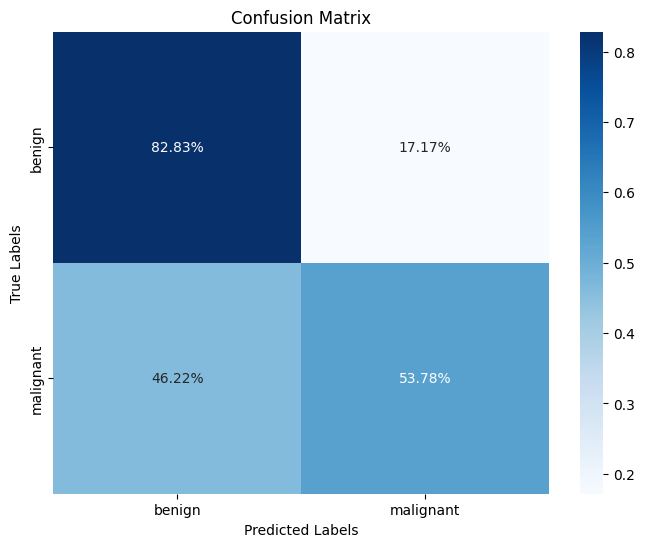

Validation Loss: 0.41313788237480015, Validation Accuracy: 82.31210383338365% Validation Time: 290.94827699661255 seconds
Precision: 0.9730940989284114,Recall: 0.8231210383338364, F1_Score: 0.8875109637742966
Epoch 8, Train Loss: 0.4132110913594564, Train Accuracy: 84.83870967741936%, Train Time: 125.27659797668457 seconds


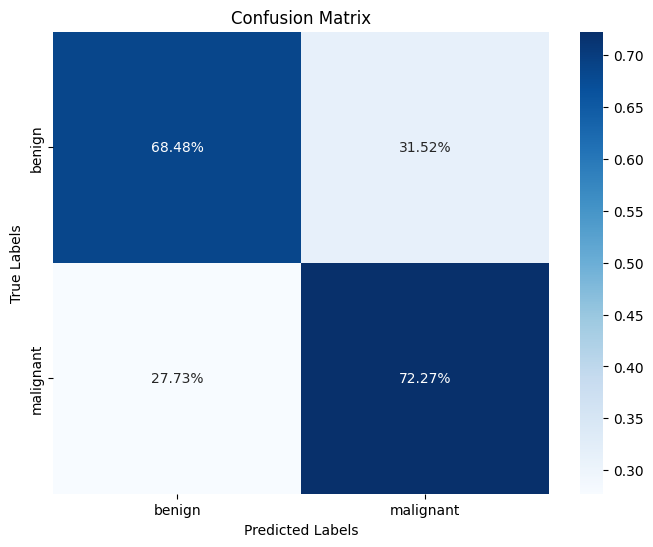

Validation Loss: 0.6057981808598225, Validation Accuracy: 68.54814367642619% Validation Time: 288.69461488723755 seconds
Precision: 0.9755439219216085,Recall: 0.685481436764262, F1_Score: 0.7972899971008575
Epoch 9, Train Loss: 0.3940399169921875, Train Accuracy: 84.83870967741936%, Train Time: 129.12097907066345 seconds


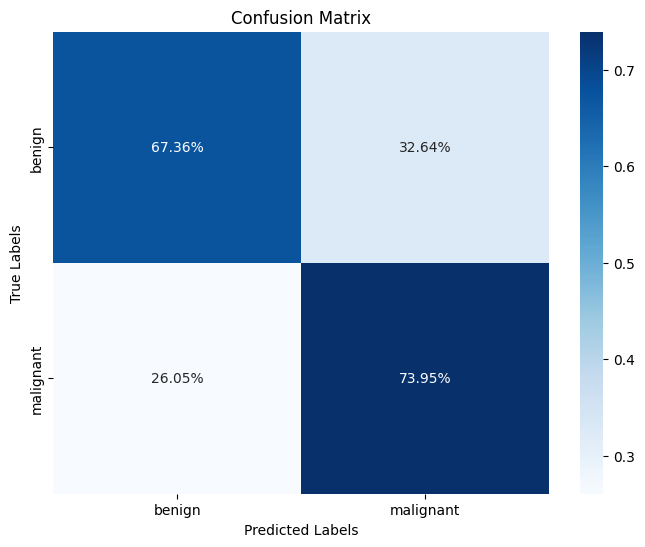

Validation Loss: 0.6296102646738291, Validation Accuracy: 67.4766073045578% Validation Time: 291.58429884910583 seconds
Precision: 0.9758579552611611,Recall: 0.674766073045578, F1_Score: 0.7896141053552901
Epoch 10, Train Loss: 0.35588813523451485, Train Accuracy: 86.7741935483871%, Train Time: 131.22575092315674 seconds


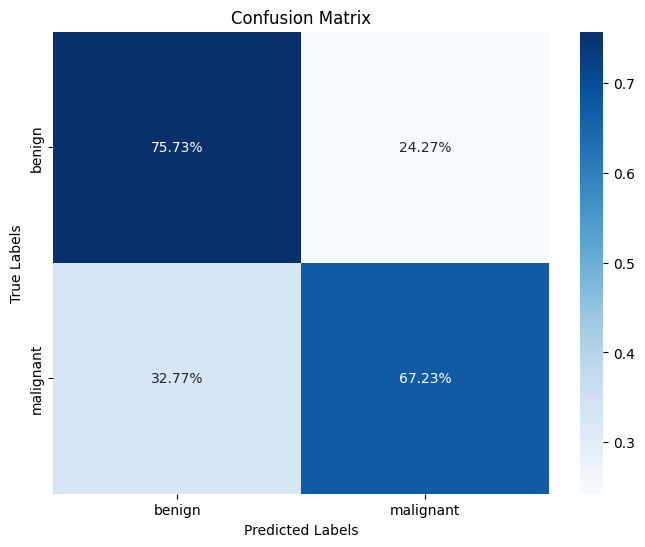

Validation Loss: 0.4930493873185836, Validation Accuracy: 75.58104437066103% Validation Time: 286.29858207702637 seconds
Precision: 0.9751956822676436,Recall: 0.7558104437066103, F1_Score: 0.8451746938497885


In [29]:
# Training and Valaidation
num_epochs = PARAMS['epochs']
optimizer,criterion = get_optimizer_and_criterion(PARAMS,model)  
for epoch in range(num_epochs):
    train_loss, train_accuracy, train_time = train_model(model, criterion, optimizer, undersampled_dataloader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}%, Train Time: {train_time} seconds")
    #wandb.log({"Training Loss": train_loss, "Training Accuracy": train_accuracy})

    # Validation
    val_loss, val_accuracy, val_time,precision,recall,f1,conf_matrix = validate_model(model, criterion, val_dataloader, device)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}% Validation Time: {val_time} seconds")
    print(f"Precision: {precision},Recall: {recall}, F1_Score: {f1}")
    #wandb.log({"Precision": precision, "Recall": recall, "F1 Score": f1})
    #wandb.log({"Validation Loss": val_loss, "Validation Accuracy": val_accuracy})    